# Проект "А/В-тест"

Наша цель - проанализировать данные интернет-магазина. Для этого мы должны сначала приоритизировать гипотезы, затем провести А/В-тест и написать выводы.

Вначале загрузим необходимые библиотеки и проверим предоставленные датасеты на наличие аномалий.

In [38]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
hypo = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
hypo.info()
hypo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
orders.info()
orders.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
734,4143391178,1373713654,2019-08-30,9850,B
123,3268937183,3722682546,2019-08-22,1450,A
279,1101659272,1648269707,2019-08-18,860,A
1144,3568767894,1964799739,2019-08-13,1490,B
225,2931845376,2954449915,2019-08-17,10791,A


In [5]:
visitors.info()
visitors.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
39,2019-08-09,B,610
49,2019-08-19,B,487
36,2019-08-06,B,655
9,2019-08-10,A,406
43,2019-08-13,B,769


In [6]:
orders.isna().sum()

transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

In [7]:
visitors.isna().sum()

date        0
group       0
visitors    0
dtype: int64

Приведём заголовки в датасете hypo к строчному формату.

In [8]:
hypo.columns = hypo.columns.str.lower()
hypo

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


Приведём данные столбца date к типу datetime.

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Удалим дубликаты в датасете orders (по столбцам date и group) и сохраним результат в переменной datesGroups.

In [10]:
datesGroups = orders[['date', 'group']].drop_duplicates()
datesGroups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62 entries, 0 to 1150
Data columns (total 2 columns):
date     62 non-null datetime64[ns]
group    62 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ KB


С датасетами всё в порядке, переходим к первой задаче: приоретизируем имеющиеся гипотезы.

## Приоритизация гипотез.


Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.


In [29]:
hypo['ICE'] = (hypo['impact'] * hypo['confidence'] / hypo['efforts']).round(2)
hypo[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день...",16.20
0,"Добавить два новых канала привлечения трафика,...",13.33
7,Добавить форму подписки на все основные страни...,11.20
6,Показать на главной странице баннеры с актуаль...,8.00
2,Добавить блоки рекомендаций товаров на сайт ин...,7.00
1,"Запустить собственную службу доставки, что сок...",2.00
5,"Добавить страницу отзывов клиентов о магазине,...",1.33
3,"Изменить структура категорий, что увеличит кон...",1.12
4,"Изменить цвет фона главной страницы, чтобы уве...",1.00


Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.


In [12]:
hypo['RICE'] = hypo['reach'] * hypo['impact'] * hypo['confidence'] / hypo['efforts']
hypo[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,Добавить форму подписки на все основные страни...,112.0
2,Добавить блоки рекомендаций товаров на сайт ин...,56.0
0,"Добавить два новых канала привлечения трафика,...",40.0
6,Показать на главной странице баннеры с актуаль...,40.0
8,"Запустить акцию, дающую скидку на товар в день...",16.2
3,"Изменить структура категорий, что увеличит кон...",9.0
1,"Запустить собственную службу доставки, что сок...",4.0
5,"Добавить страницу отзывов клиентов о магазине,...",4.0
4,"Изменить цвет фона главной страницы, чтобы уве...",3.0


Гипотезы 0 и 7 в первой тройке в обоих фреймворках - именно ими мы бы рекомендовали заняться в первую очередь. Гипотеза 8, которая в ICE занимает первое место, в RICE оказывается аж на пятом. Это произошло потому, что параметр reach составляет всего единицу, которая в ICE не учитывалась. А поскольку в других гипотезах reach составляет довольно высокие значения (к примеру, в гипотезе 7 он составляет аж 10), они - это гипотезы - поднялись вверх за счёт reach. В любом случае, **топ-5 гипотез по обоим фреймворкам получился одинаковым**.

## Анализ A/B-теста

Построим график кумулятивной выручки по группам. Прежде всего, соберём кумулятивные данные.

In [37]:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                     .agg({'date' : 'max', 
                                           'group' : 'max', 
                                           'transactionId' : pd.Series.nunique, 
                                           'visitorId' : pd.Series.nunique, 
                                           'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 
                                             'group' : 'max', 
                                             'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Кумулятивные данные собраны и сохранены в переменной cumulativeData. Теперь построим график кумулятивной выручки по группам.


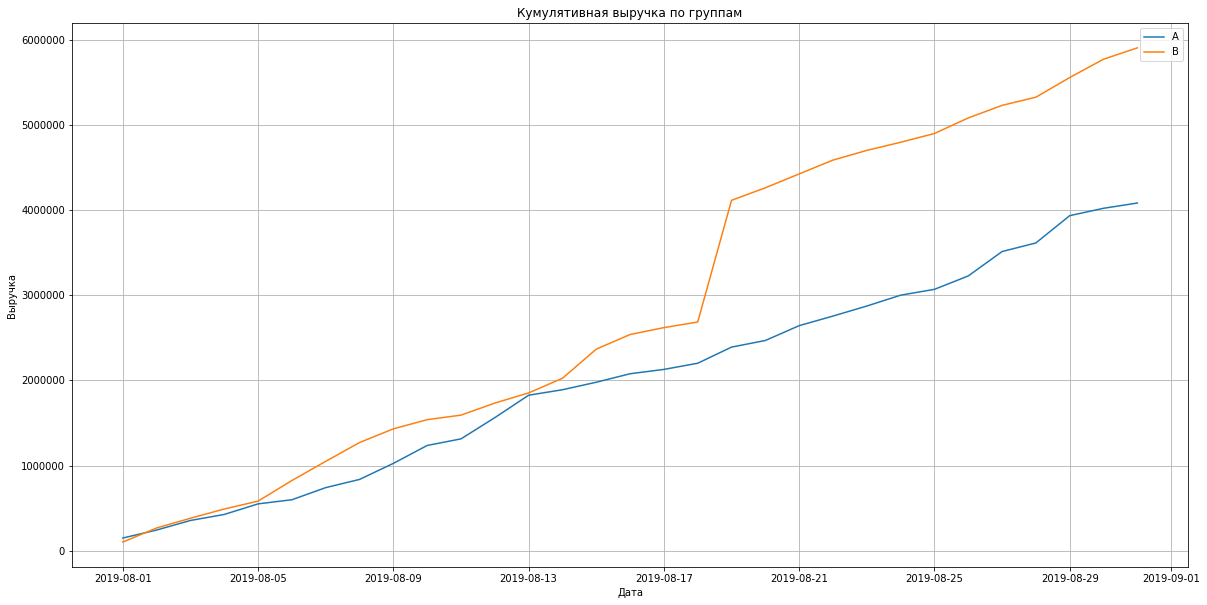

In [39]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(20, 10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend()
plt.show()

График кумулятивной выручки показывает, что выручка стабильно растёт в обеих группах. Группа В опережает группу А по выручке. График показывает резкий рост группы В в августе 2018 года - это мог быть как всплеск кол-ва заказов, так и аномально дорогие покупки. Построим график кумулятивного среднего чека по группам. Для этого разделим кумулятивную выручку на кумулятивное лисло заказов по каждой группе.

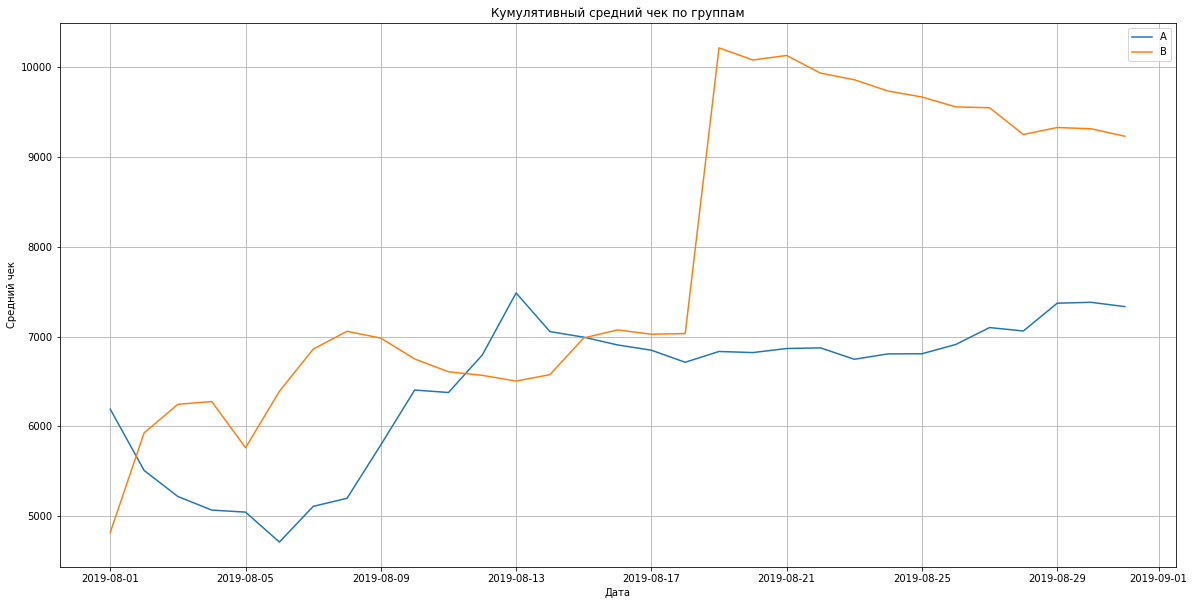

In [15]:
plt.figure(figsize=(20, 10))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend()
plt.show()

Картина та же, что на предыдущем графике: резкий рост группы В в августе 2018 года. Однако сразу после всплеска средний чек плавно снижается, в то время как в группе В с 13 августа 2018 года средний чек идёт более-менее ровно в районе 7 000 у.е. Посмотрим, на динамику кумулятивного среднего чека группы В относительно группы А, построив график.

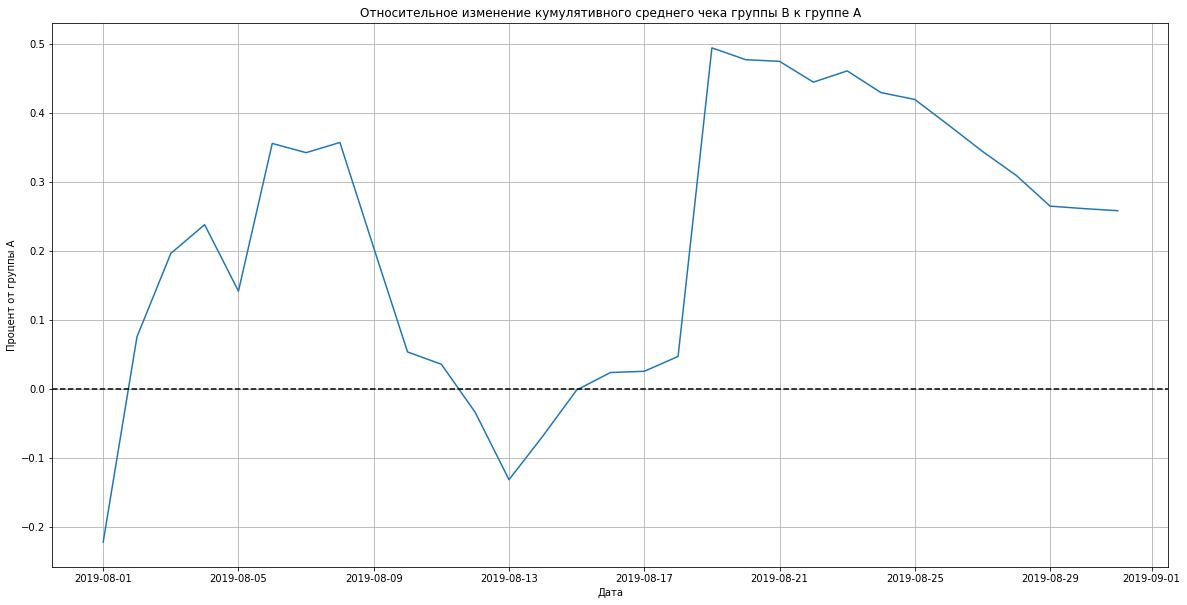

In [16]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(20, 10))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Процент от группы А')
plt.grid()
plt.show()

График сильно скачет - весьма вероятно, имели место крупные покупки. Пока никаких выводов сделать нельзя. Теперь построим график кумулятивной конверсии по группам. В качестве масштаба возьмём имеющиеся временные границы и приблизительные границы колебаний обеих групп.

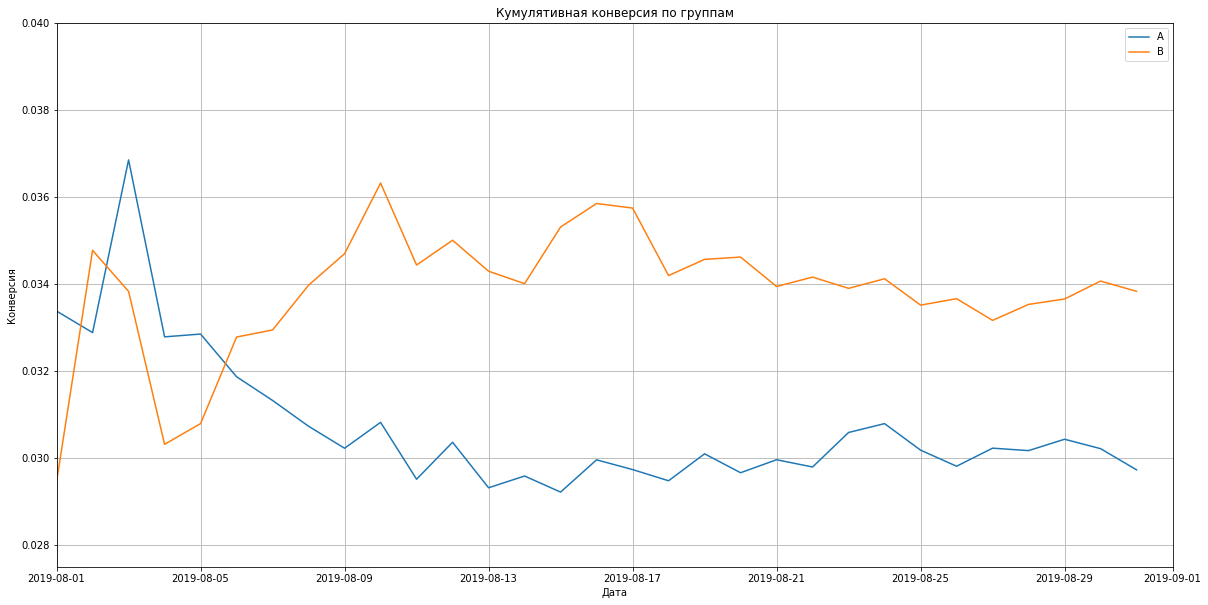

In [17]:
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(20, 10))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.grid()

plt.axis(["2019-08-01", '2019-09-01', 0.0275, 0.04])
plt.title('Кумулятивная конверсия по группам')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

Обе группы в самом начале резко скакнули и так же резко упали. Конферсия группы А продолжила падать, зафиксировавшись (с небольшими колебаниями) примерно после 9 августа 2018 года. Конверсия группы В, напротив, после резкого подъёма и падения в начале начала расти приблизительно до 10 августа, после чего испытывала колебания, пока, наконец, более-менее не зафиксировалась на уровле 0,34 у.е. Обе группы в итоге ведут себя более-менее устойчиво.

Построим график относительного изменения кумулятивной конверсии группы B к группе A.


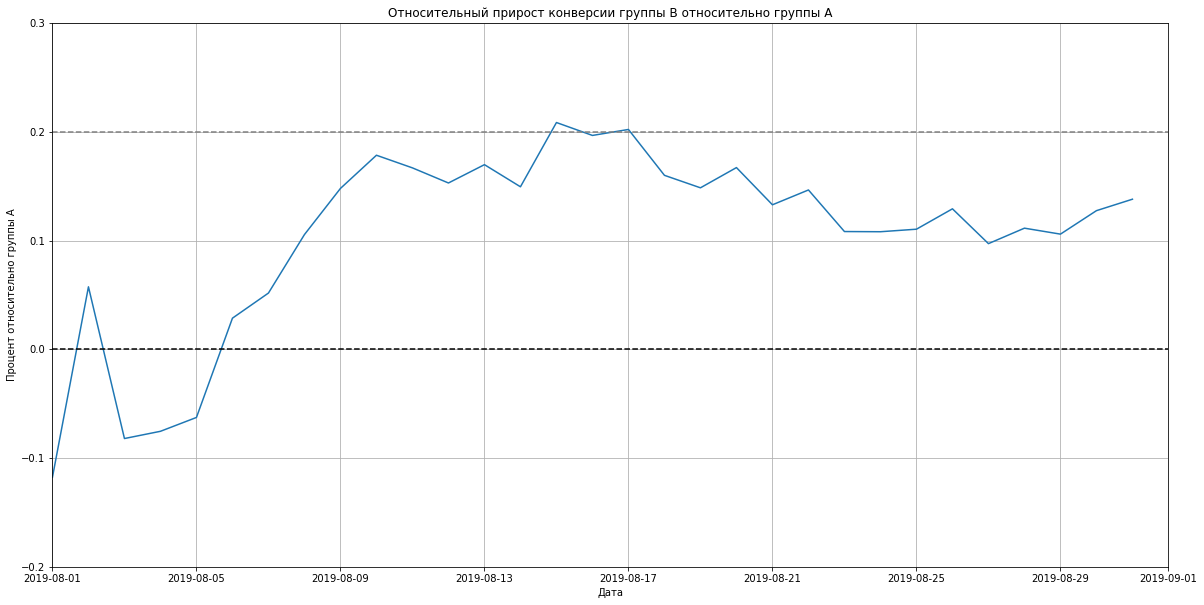

In [40]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], 
                                                                           left_on='date', 
                                                                           right_on='date', 
                                                                           how='left', 
                                                                           suffixes=['A', 'B'])
plt.figure(figsize=(20, 10))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.xlabel('Дата')
plt.ylabel('Процент относительно группы А')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.2, 0.3])
plt.grid()
plt.show()

Коверсия группы В начала расти 5 августа 2018 года, достигнув максимума примерно 15 августа, превышая на этой точке конверсию группы А чуть более чем на 20%. Затем конферсия группы В начала снижаться, зафиксировавшись на показателе 10% от конверсии группы А примерно 23 августа. Поскольку стабилизация конверсии произошла ближе к концу периода, делать какие-либо окончательные выводы было бы опрометчиво. Пойдём дальше.

Построим точечный график количества заказов по пользователям. Для этого создадим переменную ordersByUsers, в которой сохраним данные датасета orders, удалив ненужные нам столбцы group, revenue и date, сгруппировав по столбцу visitorId и подсчитав уникальные значения столбца transactionId.

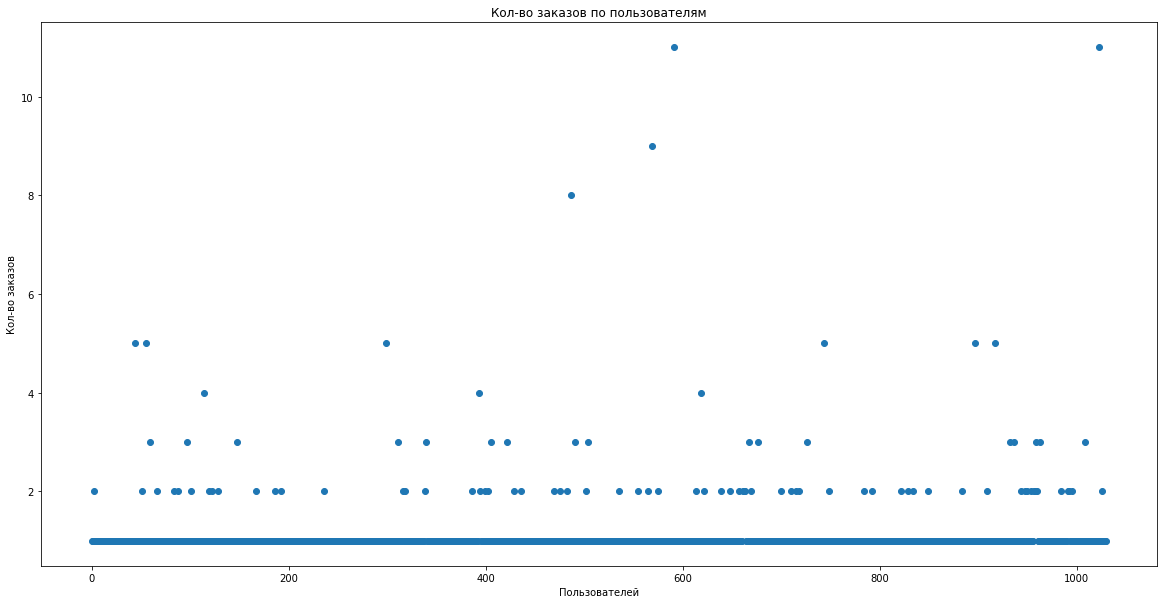

In [19]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.figure(figsize=(20, 10))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Кол-во заказов по пользователям')
plt.xlabel('Пользователей')
plt.ylabel('Кол-во заказов')
plt.show()

Судя по графику, пользователей, совершивших больше 2 покупок, немного. Чтобы понять, является ли аномалией наличие больше двух заказов, посчитаем 95-й и 99-й перцентили количества заказов на пользователя.

In [20]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей оформляли больше 2 заказов. Не более 1% пользователей оформляли более 4 заказов. Выберем за нижнюю границу числа заказов 2 покупки на одного пользователя, остальное отсеим как аномалии. Теперь построим точечный график стоимостей заказов.

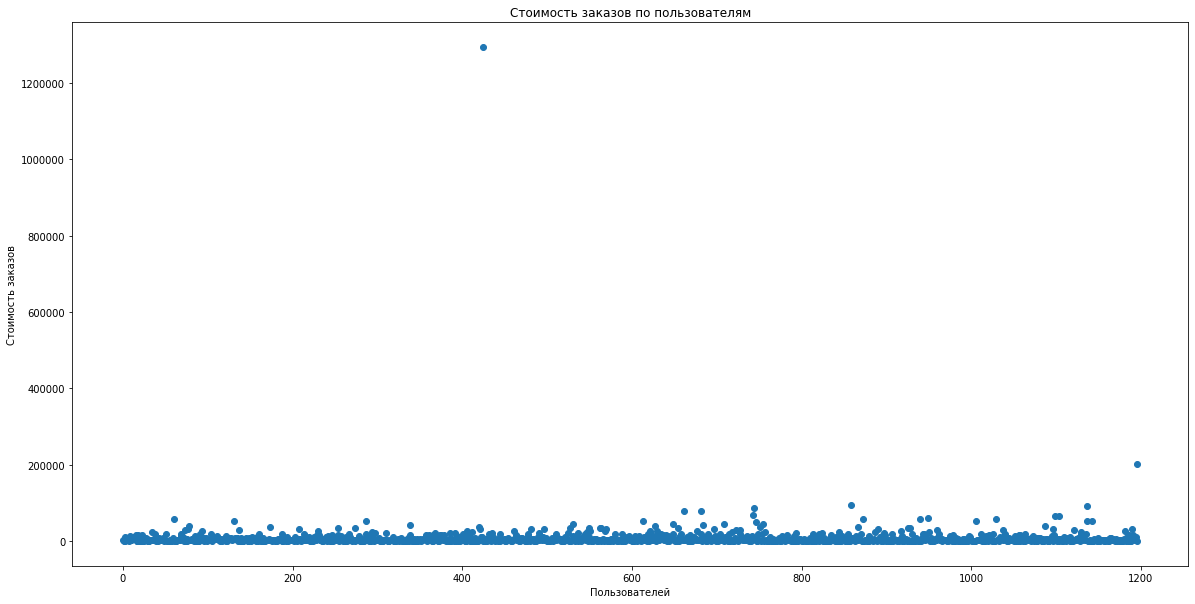

In [21]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(20, 10))
plt.scatter(x_values, orders['revenue'])
plt.title('Стоимость заказов по пользователям')
plt.xlabel('Пользователей')
plt.ylabel('Стоимость заказов')
plt.show()

График чётко показыват два выброса: один свыше 1 200 000 у.е. (1 294 500, если быть точным), второй - около 200 000 у.е. (конкретнее - 202 740 у.е.). Это именно те дорогие заказы, которые искажают данные.

Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [22]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% пользователей чек составил 28 000 у.е., не более, чем у 1% - 58 233 у.е. Будем считать аномалиями все заказы свыше 28 000 у.е.

Посчитаем статистическую значимость различий в конверсии между группами по «сырым» данным. Создадим две переменные: visitorsADaily и visitorsBDaily, в которых сохраним число пользователей за дату по каждой группе. Затем посчитаем суммарное кол-во пользователей до выбранной даты по каждой группе.

Создадим две переменные: ordersADaily и ordersBDaily, в которых из датасета orders сохраним дату и посетителей каждой группы. Затем посчитаем кумулятивные данные по каждой группе из датасетов orders и visitors и замерджим их все, сохранив в переменной data.

In [23]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Теперь посчитаем статистическую значимость различия в конверсии между группами. Уровень значимости возьмём 0.05. В тесте Манна-Уитни используем параметр "two-sided", чтобы p-value выводилось полностью.

Гипотезы сформулируем так:

- Н0 - существует статистически значимая разница между группами А и В.
- Н1 - нет подтверждения статистически значимой разницы между группами А и В.

In [24]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)
alpha = 0.05
results = stats.mannwhitneyu(sampleA, sampleB, True, 'two-sided')
print("p-value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, True, 'two-sided')[1]))
print("{0:.3f}".format((data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum())/(data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum())-1))
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

p-value: 0.017
0.138
Отвергаем нулевую гипотезу: разница статистически значима


P-value равно 0.017 - это меньше 0.05, следовательно, нулевую гипотезу мы отвергаем. Это говорит о том, что существуют статистически значимые различие в конверсии между группами. А прирост группы В к группе А составляет почти 14%.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [25]:
results1 = stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], True, 'two-sided')

print('{0:.3f}'.format(results1[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
if results1.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

0.729
0.259
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


P-value существенно больше 0.05 - между группами не удалось найти статистические отличия в среднем чеке. Различие между группами составляет почти 26%.

Посчитаем статистическую значимость различий в конверсии между группами по «очищенным» данным.

In [26]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
results2 = stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'two-sided')
print('p-value: {0:.5f}'.format(results2[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))
if results2.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')                           

p-value: 0.01304
0.173
Отвергаем нулевую гипотезу: разница статистически значима


P-value снова меньше 0.05, как и в анализе "сырых" данных. Различие между группами составляет 17.3% - даже выше, чем в "сырых" данных.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.


In [27]:
results3 = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], True, 'two-sided'
        )
print('{0:.3f}'.format(results3[1]))

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)
if results3.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя') 

0.738
-0.020
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


По "очищенным" данным статистическая значимость различий в среднем чеке заказа между группами составляет 0.738 - вновь больше, чем 0.05. Кроме того, средний чек группы В меньше группы А.

Итак, мы имеем следующее. 

Во-первых, существуют статистически значимые различие в конверсии между группами как по "сырым", так и по "обработанным" данным.

Во-вторых, при анализе групп по среднему чеку НЕ удалось отвергнуть нулевую гипотезу, т.е. вывод о различии сделать нельзя; это справедливо как до, так и после обработки данных.

В-третьих, график различия конверсии между группами показывает рост конверсии группы В, хотя и местами неустойчивый. Хотя он более-менее фиксируется на показателе 10% от конверсии группы А, нельзя сказать, что это фиксирование устойчивое.

В-четвёртых, график относительного изменения кумулятивного среднего чека группы В к группе А сильно скачет. В нём никак нельзя усмотреть какие-либо тенденции.

Все полученные данные говорят о том, что имеет смысл продолжить тест и посмотреть, как изменится анализ групп по среднему чеку после обработки данных, а также понаблюдать за дальнейшней динамикой графика различия конверсии между группами.

Итак, завершать тест рано. Рекомендуем продолжить его.

## Вывод

Перед нами была поставлена цель подготовить аналитику по предоставленным данным. Для достижения цели мы выполнили следующие задачи: 1) приоритезировали гипотезы и 2) осуществили А/В-тест. Рассмотрим подробнее шаги, которые мы осуществили.

Для приоретизации мы выбрали методы ICE и RICE. Оба метода показали, что в топ-5 гипотез, которые нужно проверить, входят одни и те же гипотезы: 0, 2, 6, 7, 8. Мы можем рекомендовать в первую очередь проверить гипотезы 0 и 7 - именно они в первой тройке в обоих фреймворках.

Затем мы приступили к проведению А/В-теста. Мы собрали кумулятивные данные, разбили пользователей на группы А и В и построили график кумулятивной выручки. Он показал, что выручка стабильно растёт в обеих группах, при этом группа В опережает по выручке группу А. Далее мы изучили динамику кумулятивного среднего чека по группам, которая также показала рост среднего чека группы В, опрежеющий группу А. Впрочем, построив график относительного изменения кумулятивного среднего чека группы В к группе А, стало ясно, что пока делать какие-либо выводы рано - график сильно "скачет".

Далее мы построили график кумулятивной конверсии по группам, который показал, что обе группы в самом начале резко скакнули вверх и также резко упали, после чего испытывали более-менее значительные колебания, пока, наконец, не показали относительную устойтивость. Мы построили график относительного пироста конферсии группы В относительно группы А, показавший, что стабилизация конверсии произошла ближе к концу исследуемого периода, из-за чего делать какие-либо окончательные выводы было бы опрометчиво.

Построив несколько графиков, на которых отражалось количество и стоимость заказов по пользователям, мы увидели несколько выбросов, которые могли существенно исказить дальнейшие исследования. Отсеяв все выбросы и аномалии (за них мы, благодаря вычислениям перцентилей, приняли заказы свыше 28 000 руб.), мы приступили к вычислениям статистической значимости различий в конверии по "сырым" и "обработанным" данным, отдельно посчитав статистическую значимость различий по среднему чеку.

Результаты показали, что, с одной стороны, существуют статистически значимые различие в конверсии между группами как по "сырым", так и по "обработанным" данным, но с другой,  при анализе групп по среднему чеку это различие выявлено не было.

Всё это говорит о том, что имеет смысл продолжить тест, тем более, что тест пока ещё длится недостаточно долго. Нужно посмотреть, как в дальнейшем изменится динамика среднего чего по группам, а также динамика различия конверсии между группами. Рекомендуем продолжить тест.